In [1]:
!pip install timm
import timm
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np


In [2]:
from google.colab import files
uploaded = files.upload()


Saving DataSet.rar to DataSet.rar


In [6]:
import os

zip_path = "/content/DataSet.rar"
extract_dir = "/content/Dataset"

# Install unrar in Colab
!apt-get install unrar

# Create directory and extract
os.makedirs(extract_dir, exist_ok=True)
!unrar x "{zip_path}" "{extract_dir}/"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/DataSet.rar

Creating    /content/Dataset/DataSet                                  OK
Creating    /content/Dataset/DataSet/Data_cloudy                      OK
Extracting  /content/Dataset/DataSet/Data_cloudy/train_10021.jpg           0%  OK 
Extracting  /content/Dataset/DataSet/Data_cloudy/train_10070.jpg           0%  OK 
Extracting  /content/Dataset/DataSet/Data_cloudy/train_10096.jpg           0%  OK 
Extracting  /content/Dataset/DataSet/Data_cloudy/train_101.jpg             0%  OK 
Extracting  /content/Dataset/DataSet/Data_cloudy/train_10128.jpg           0%  OK 
Extracting  /content/Dataset/DataSet/Data_cloudy/train_10177.

**1.2 Data Preprocessing**

In [7]:
from torch.utils.data import random_split, DataLoader


In [10]:
import os

data_dir = "/content/Dataset/DataSet"
print(os.listdir(data_dir))


['Data_water', 'Data_cloudy', 'Data_desert', 'Data_green_area']


In [11]:
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

# Path to your dataset
data_dir = "/content/Dataset/DataSet"

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
dataset = ImageFolder(root=data_dir, transform=transform)

# Show class names
class_names = dataset.classes
print("Classes:", class_names)

# Split dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Data loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)


Classes: ['Data_cloudy', 'Data_desert', 'Data_green_area', 'Data_water']


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model('convnext_base', pretrained=True, num_classes=4)
model.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), g

In [13]:
import torch.nn as nn
import torch.optim as optim


In [14]:

import torch.optim as optim
from time import time
from tqdm import tqdm  # For progress bar

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler()

# Store metrics
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

# Training loop
for epoch in range(3):
    print(f"\nEpoch {epoch+1}/3")
    start_time = time()

    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Mixed precision forward pass
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Backward and optimize
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100 * correct / total
    train_loss_list.append(train_loss / len(train_loader))
    train_acc_list.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100 * correct / total
    val_loss_list.append(val_loss / len(val_loader))
    val_acc_list.append(val_acc)

    elapsed = time() - start_time
    print(f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Time: {elapsed:.1f}s")


/tmp/ipython-input-1250464495.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 1/3


  0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipython-input-1250464495.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 40/40 [00:41<00:00,  1.04s/it]
/tmp/ipython-input-1250464495.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Acc: 82.70% | Val Acc: 98.15% | Time: 47.8s

Epoch 2/3


100%|██████████| 40/40 [00:15<00:00,  2.54it/s]


Train Acc: 99.29% | Val Acc: 100.00% | Time: 17.1s

Epoch 3/3


100%|██████████| 40/40 [00:15<00:00,  2.59it/s]


Train Acc: 100.00% | Val Acc: 100.00% | Time: 17.3s


In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Augmentation
    transforms.RandomRotation(10),      # Augmentation
    transforms.ToTensor()
])


In [16]:
from collections import Counter
labels = [label for _, label in dataset.samples]
print(Counter(labels))


Counter({0: 500, 1: 500, 2: 500, 3: 300})


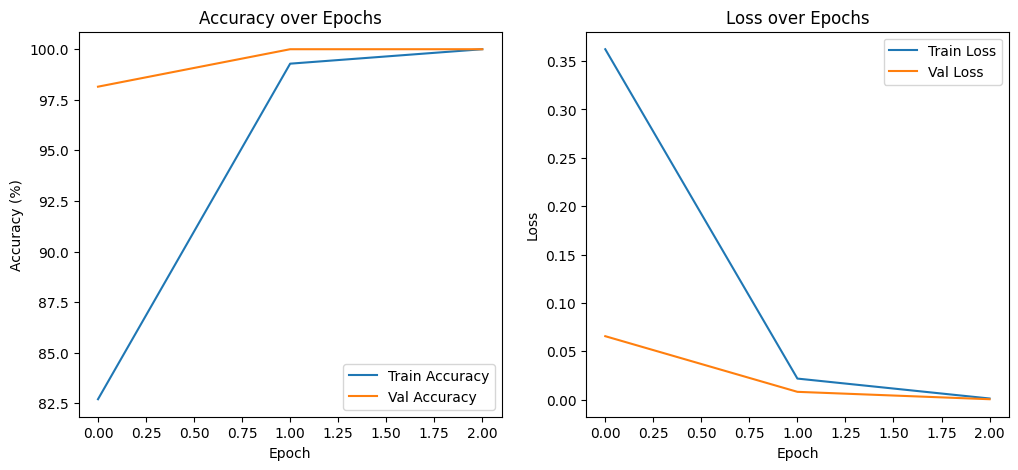

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test data
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))


                 precision    recall  f1-score   support

    Data_cloudy       1.00      1.00      1.00        66
    Data_desert       1.00      1.00      1.00        87
Data_green_area       1.00      1.00      1.00        75
     Data_water       1.00      1.00      1.00        42

       accuracy                           1.00       270
      macro avg       1.00      1.00      1.00       270
   weighted avg       1.00      1.00      1.00       270



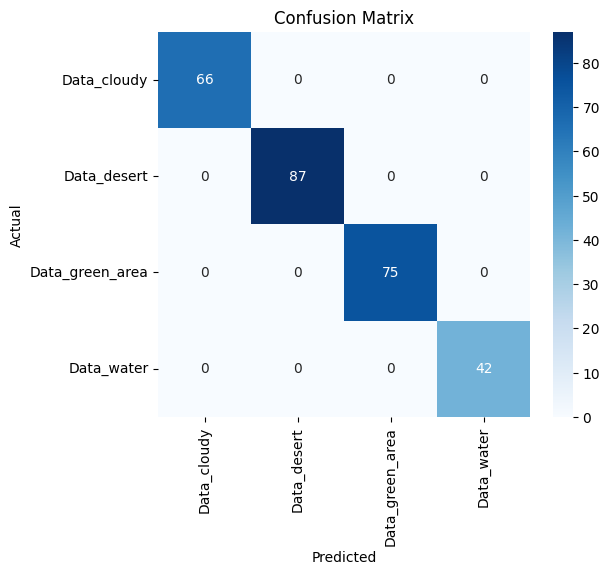

Specificity for class 'Data_cloudy': 1.00
Specificity for class 'Data_desert': 1.00
Specificity for class 'Data_green_area': 1.00
Specificity for class 'Data_water': 1.00


In [19]:
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Specificity Calculation (for each class)
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (FP + FN + TP)

specificity = TN / (TN + FP)
for idx, spec in enumerate(specificity):
    print(f"Specificity for class '{class_names[idx]}': {spec:.2f}")
